In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import yfinance as yf


#import AAPL csv, csv data is different from yahoo finance
ticker = "AAPL"
start  = "2017-01-01"
end    = "2025-01-01"
csv_AAPL = yf.download(ticker, start=start, end=end).reset_index()
#since date type is just a object convert it to a datetime object
csv_AAPL['Date'] = pd.to_datetime(csv_AAPL['Date'])

#declare the features
features = ['Close','High','Low','Open','Volume']

#declare the type of scalar you're using
scaler = StandardScaler()
csv_AAPL[features] = scaler.fit_transform(csv_AAPL[features])

#drop unneeded values and then create a new csv
# drops Date (or any other non‑numeric columns) if you haven’t already
df_model = csv_AAPL.drop(columns=['Date'])

# save
df_model.to_csv('../../data/individual_tickers/scaled_data.csv', index=False)
print("Saved cleaned & scaled data to scaled_data.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Saved cleaned & scaled data to scaled_data.csv



/var/folders/pt/tqsxvwfn1hz_35ct12bq5tdh0000gn/T/ipykernel_41312/157254786.py:23: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_model = csv_AAPL.drop(columns=['Date'])


Iteration 1, loss = 0.36377843
Iteration 2, loss = 0.11516247
Iteration 3, loss = 0.02066880
Iteration 4, loss = 0.00622719
Iteration 5, loss = 0.00534309
Iteration 6, loss = 0.00161981
Iteration 7, loss = 0.00144755
Iteration 8, loss = 0.00096809
Iteration 9, loss = 0.00074566
Iteration 10, loss = 0.00064236
Iteration 11, loss = 0.00057317
Iteration 12, loss = 0.00051617
Iteration 13, loss = 0.00047188
Iteration 14, loss = 0.00043691
Iteration 15, loss = 0.00040465
Iteration 16, loss = 0.00037582
Iteration 17, loss = 0.00034935
Iteration 18, loss = 0.00032436
Iteration 19, loss = 0.00030364
Iteration 20, loss = 0.00028621
Iteration 21, loss = 0.00026999
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Test MSE: 0.0135
Test R²:  0.9172


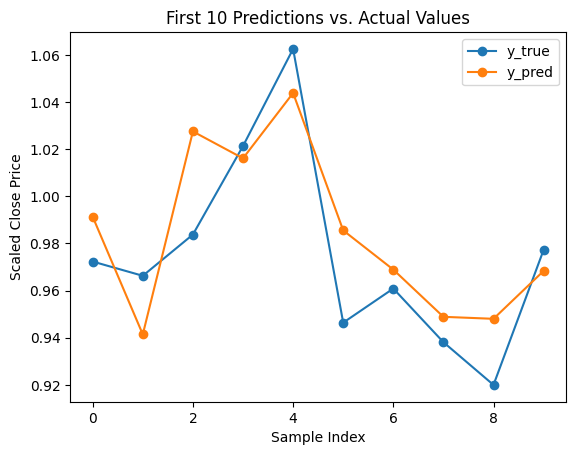

In [13]:
# #This cell is for ur model
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.neural_network import MLPRegressor
# from sklearn.metrics import mean_squared_error, r2_score

# #prep features and drop unneeded data
# X = df_model.drop(columns=['Close'])
# y = df_model['Close'].values  # <- this makes y a 1-D numpy array

# #Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.1, shuffle=False,random_state=42)

# #instantiate and fit MLP
# mlp_model = MLPRegressor(hidden_layer_sizes=(64,64),activation='relu',solver='adam',
#                          learning_rate_init=1e-3,max_iter=200,random_state=42,verbose=True)

# mlp_model.fit(X_train,y_train.ravel())
# #remember convergence shows that when model reaches stable state it doesnt improve

# #evaluate the model
# y_pred = mlp_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2  = r2_score(y_test, y_pred)

# print(f"Test MSE: {mse:.4f}")
# print(f"Test R²:  {r2:.4f}")

# #predictions vs actual
# y_true_10 = y_test[:10]
# y_pred_10 = y_pred[:10]  # already 1-D

# # pd.DataFrame({
# #     'y_true': y_true_10,
# #     'y_pred': y_pred_10,
# # }).plot(marker='o')

# df_plot = pd.DataFrame({'y_true': y_true_10, 'y_pred': y_pred_10})
# df_plot.plot(marker='o')
# plt.title("First 10 Predictions vs. Actual Values")
# plt.xlabel("Sample Index")
# plt.ylabel("Scaled Close Price")
# plt.show()

# Fixed Model Training & Plotting Cell

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1) Prepare features (X) and target (y) as 1-D array
X = df_model.drop(columns=['Close'])
y = df_model['Close'].to_numpy().ravel()  # now y.shape == (n,)

# 2) Train/test split (10% test, chronological)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False, random_state=42
)

# 3) Instantiate and fit MLP
mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 64),
    activation='relu',
    solver='adam',
    learning_rate_init=1e-3,
    max_iter=200,
    random_state=42,
    verbose=True
)
mlp_model.fit(X_train, y_train)

# 4) Evaluate on test set
y_pred = mlp_model.predict(X_test)
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test R²:  {r2_score(y_test, y_pred):.4f}")

# 5) Plot the first 10 predictions vs. actuals
y_true_10 = y_test[:10]   # already 1-D
y_pred_10 = y_pred[:10]

df_plot = pd.DataFrame({'y_true': y_true_10, 'y_pred': y_pred_10})
df_plot.plot(marker='o')
plt.title("First 10 Predictions vs. Actual Values")
plt.xlabel("Sample Index")
plt.ylabel("Scaled Close Price")
plt.show()



/var/folders/pt/tqsxvwfn1hz_35ct12bq5tdh0000gn/T/ipykernel_41312/46203052.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = df_fe.drop(columns=['Date','Close'])


Iteration 1, loss = 0.17915254
Iteration 2, loss = 0.01245878
Iteration 3, loss = 0.00437189
Iteration 4, loss = 0.00160342
Iteration 5, loss = 0.00117722
Iteration 6, loss = 0.00080925
Iteration 7, loss = 0.00096861
Iteration 8, loss = 0.00075787
Iteration 9, loss = 0.00053391
Iteration 10, loss = 0.00056486
Iteration 11, loss = 0.00044004
Iteration 12, loss = 0.00040219
Iteration 13, loss = 0.00038105
Iteration 14, loss = 0.00035985
Iteration 15, loss = 0.00039246
Iteration 16, loss = 0.00036344
Iteration 17, loss = 0.00036383
Iteration 18, loss = 0.00042197
Iteration 19, loss = 0.00054284
Iteration 20, loss = 0.00042073
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Test MSE: 0.0014
Test R²:  0.9905


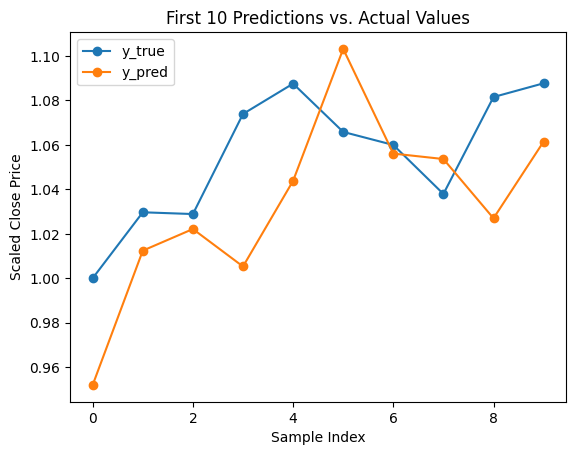

In [27]:
#=== Feature engineering + model training cell ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1) Start from your cleaned & scaled df_model (must include 'Date' & 'Close')
df_fe = csv_AAPL.copy()

# 2) Add lag and rolling‑window features (all shifted by 1 day)
df_fe['Close_lag1']     = df_fe['Close'].shift(1)
df_fe['MA_5']           = df_fe['Close'].rolling(window=5).mean().shift(1)
df_fe['Volatility_5']   = df_fe['Close'].rolling(window=5).std().shift(1)

# 3) Encode weekday cyclically
df_fe['Weekday']        = df_fe['Date'].dt.weekday
df_fe['Weekday_sin']    = np.sin(2 * np.pi * df_fe['Weekday'] / 7)
df_fe['Weekday_cos']    = np.cos(2 * np.pi * df_fe['Weekday'] / 7)

# 4) Drop rows with NaNs (first few days lack history)
df_fe.dropna(inplace=True)

# 5) Prepare X and y
X = df_fe.drop(columns=['Date','Close'])
y = df_fe['Close'].to_numpy().ravel()

# 6) Train/test split (80/20 chronological)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# 7) Instantiate and fit your MLP
mlp_model = MLPRegressor(
    hidden_layer_sizes=(128,128,128), #the more data there is the more neurons needed, due to our features
    alpha=1e-4,
    activation='relu',
    solver='adam',
    learning_rate_init=0.01, 
    max_iter=200,
    random_state=42,
    verbose=True
)
mlp_model.fit(X_train, y_train)

# 8) Evaluate
y_pred = mlp_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²:  {r2:.4f}")

# 9) Quick plot of first 10 true vs. predicted
# pd.DataFrame({
#     'y_true': y_test.values[:10],
#     'y_pred': y_pred[:10],
# }).plot(marker='o')
y_true_10 = y_test[:10]   # already 1-D
y_pred_10 = y_pred[:10]

df_plot = pd.DataFrame({'y_true': y_true_10, 'y_pred': y_pred_10})
df_plot.plot(marker='o')
plt.title("First 10 Predictions vs. Actual Values")
plt.xlabel("Sample Index")
plt.ylabel("Scaled Close Price")
plt.show()


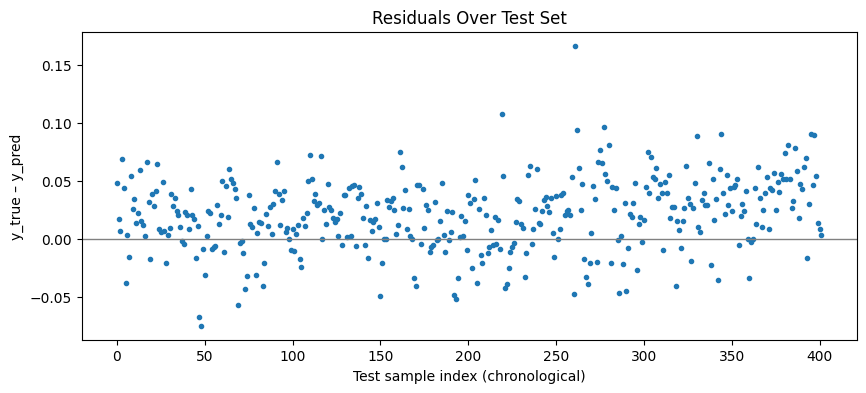

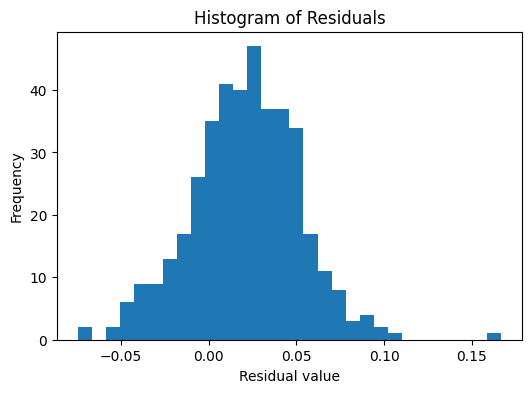

In [28]:
import matplotlib.pyplot as plt

# 1.1 Compute residuals
y_pred = mlp_model.predict(X_test)
residuals = y_test - y_pred

# 1.2 Plot residuals over time (chronologically)
plt.figure(figsize=(10,4))
plt.plot(residuals, marker='.', linestyle='none')
plt.axhline(0, color='gray', linewidth=1)
plt.title("Residuals Over Test Set")
plt.xlabel("Test sample index (chronological)")
plt.ylabel("y_true – y_pred")
plt.show()

# 1.3 Plot residual histogram
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residual value")
plt.ylabel("Frequency")
plt.show()


In [38]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neural_network import MLPRegressor

# Time-series-aware split
tscv = TimeSeriesSplit(n_splits=5)

# Define full search space
param_grid = {
    'hidden_layer_sizes': [
        (64,),              # shallow
        (128,),             # medium
        (128, 64),          # 2 layers
        (128, 128),         # 2 deeper
        (128, 128, 64),     # your current
        (256, 128, 64)      # even deeper
    ],
    'learning_rate_init': [1e-2, 5e-3, 1e-3, 5e-4],
    'alpha': [0, 1e-5, 1e-4, 1e-3]
}

# Wrap the regressor in GridSearchCV
grid = GridSearchCV(
    estimator=MLPRegressor(
        activation='relu',
        solver='adam',
        max_iter=200,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1  # parallelize search if possible
)

# Fit the grid search
grid.fit(X_train, y_train)

# Output best model info
print("✅ Best Parameters:", grid.best_params_)
print("📉 Best CV MSE:", -grid.best_score_)

# Optional: Save best model
# import joblib
# joblib.dump(grid.best_estimator_, 'best_mlp_model.pkl')



Fitting 5 folds for each of 96 candidates, totalling 480 fits
✅ Best Parameters: {'alpha': 0, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01}
📉 Best CV MSE: 0.008254437128634332
